# Rock paper scissors

We'll use Rock, Paper, Scissors dataset created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

![rock_paper_scissors](images/rock_paper_scissors.png)

In [ ]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from pytorched.step_by_step import StepByStep
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize, CenterCrop

from tqdm.autonotebook import tqdm

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from torchvision.datasets import ImageFolder
from data_generation.rps import download_rps

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|code-fold: true 
def show_image(im, cmap=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(im, cmap=cmap)
    plt.grid(False)
    plt.show()

# Data

In [ ]:
#|code-fold: true 
#|output: false
download_rps()

rps folder already exists!
rps-test-set folder already exists!


## Temporary dataset

We need to calculate normalization parameters (mean and std) for all training images first. This is important step as we will use these normalization parameters not only for training images but for all the validation, and any future, predictions. Since we need to only calculate normalization parameters, we can also scale images to smaller size, just so the calculation is faster.

In [ ]:
composer = Compose([Resize(28),
                    ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=composer)
temp_loader = DataLoader(temp_dataset, batch_size=32)
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

## Real dataset

In [ ]:
composer = Compose([Resize(28), ToTensor(), normalizer])
train_dataset = ImageFolder(root='rps', transform=composer)
val_dataset = ImageFolder(root='rps-test-set', transform=composer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
train_loader

<torch.utils.data.dataloader.DataLoader>

In [ ]:
labels

tensor([2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 1])

# Deep model

We'll use `CrossEntropyLoss` (and not add `LogSoftmax` layer):

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_filters, p=0.3):
        super(CNN2, self).__init__()
        
        self.n_filters = n_filters
        self.p = p
        
        # conv1 takes (3,28,28) and outputs (n_filters,26,26)
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=n_filters, 
            kernel_size=3
        )
        
        # conv2 takes (n_filters,13,13) and outputs (n_filters,11,11)
        self.conv2 = nn.Conv2d(
            in_channels=n_filters, 
            out_channels=n_filters, 
            kernel_size=3
        )
        
        self.fc1 = nn.Linear(n_filters*5*5, 50)
        self.fc2 = nn.Linear(50,3)
        
        self.drop = nn.Dropout(p)
        
    def featurizer(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)  # (n_filters,13,13)
        
        x = self.conv2(x)  # n_filters,11, 11 
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)  # (n_filters,5,5)
        
        x = nn.Flatten()(x)
        return x
    
        
    def classifier(self, x):
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        x = nn.Flatten()(x)
        return x
        
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x
    

In [ ]:
model_cnn = CNN2(5, 0.3)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=3e-4)
multi_loss_fn = nn.CrossEntropyLoss()

In [ ]:
sbs = StepByStep(model_cnn, optimizer_cnn, multi_loss_fn)
sbs.set_loaders(train_loader, val_loader)

In [ ]:
sbs.train(10)

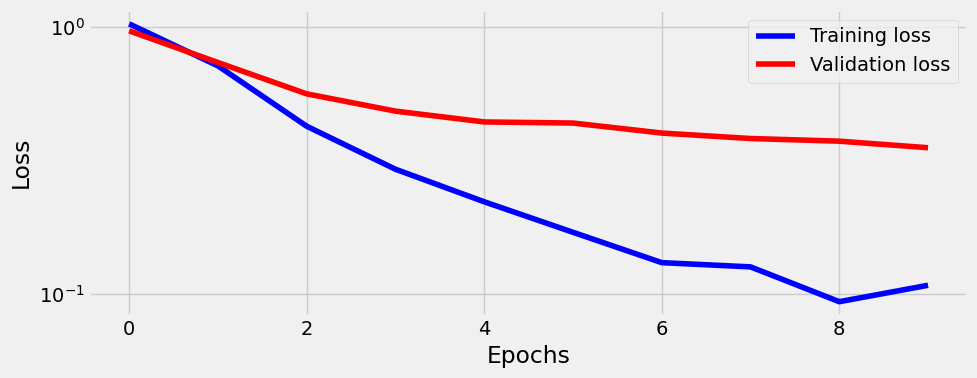

In [ ]:
fig = sbs.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs.loader_apply(sbs.val_loader, sbs.correct))

Correct categories:
tensor([[ 90, 124],
        [ 94, 124],
        [104, 124]])


In [ ]:
#|code-fold: true 
print(f'Accuracy: {sbs.accuracy}%')

Accuracy: 77.42%


In [ ]:
sbs.train(30)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [05:03<00:00, 10.12s/it]


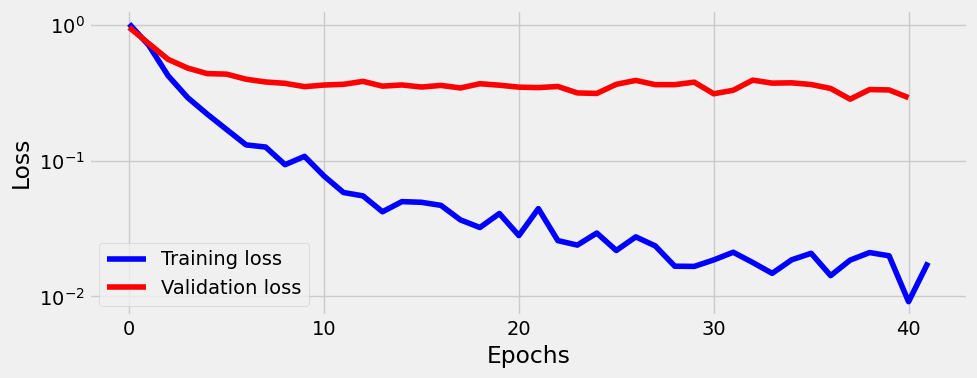

In [ ]:
fig = sbs.plot_losses()

In [ ]:
#|code-fold: true
print('Correct categories:')
print(sbs.loader_apply(sbs.val_loader, sbs.correct))

Correct categories:
tensor([[107, 124],
        [103, 124],
        [105, 124]])


In [ ]:
#|code-fold: true 
print(f'Accuracy: {sbs.accuracy}%')

Accuracy: 84.68%


# Visualize filters

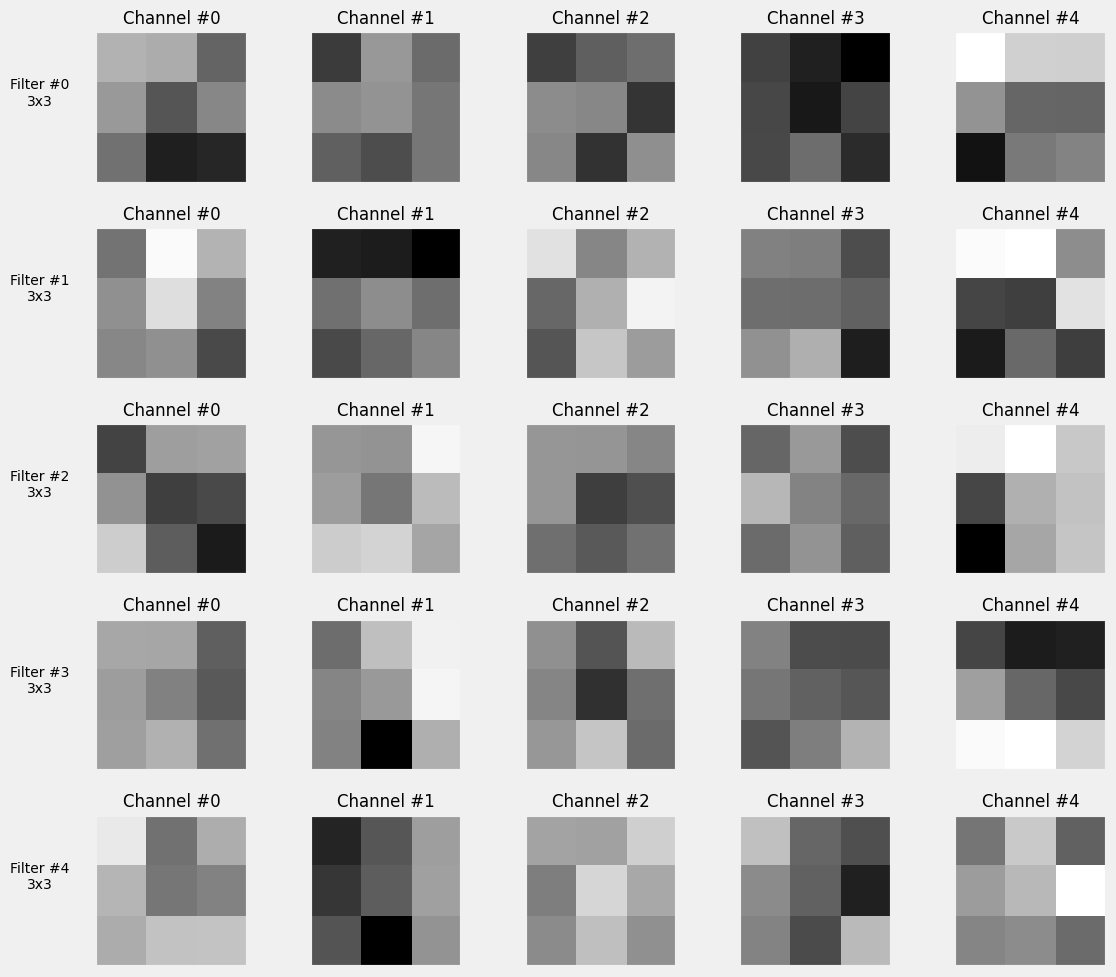

In [ ]:
fig_filters = sbs.visualize_filters('conv2', cmap='gray')

Not too informative.

# Learning Rate Finder

There is an off-the-shelf LRFinder:

In [ ]:
#!pip install --quiet torch-lr-finder
from torch_lr_finder import LRFinder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.02E-03


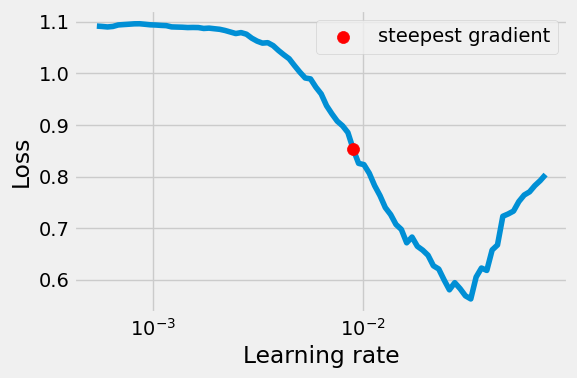

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
model_cnn = CNN2(5, 0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model_cnn.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(model_cnn, optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

We can replicate the above by using scheduler module `torch.optim.lr_scheduler` for example `LambdaLR` (there are other schedulers: `StepLR`, `ReduceLROnPlateau`,
`MultiStepLR`, `CyclicLR`). These work by steping through iterations of learning rates, using `step` method (similar to optimizer `step`).

We first define a function that can make linear or exponential scalling factors between `start_lr` and `end_lr`:

In [ ]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter    
        def lr_fn(iteration):
            return np.exp(factor)**iteration    
    return lr_fn

If we now make optimizer and scheduler, we can step through and see that learning late changes with each step:

In [ ]:
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)
scheduler = LambdaLR(optimizer_cnn, lr_lambda=make_lr_fn(0.01, 0.1, 10))

In [ ]:
for _ in range(3):
    print(scheduler.get_last_lr())
    optimizer_cnn.step()
    scheduler.step()

[0.01]
[0.012589254117941673]
[0.015848931924611138]


We can make a `lr_range_test` method that is using this scheduler, and use it to plot the loss for different learning rates:

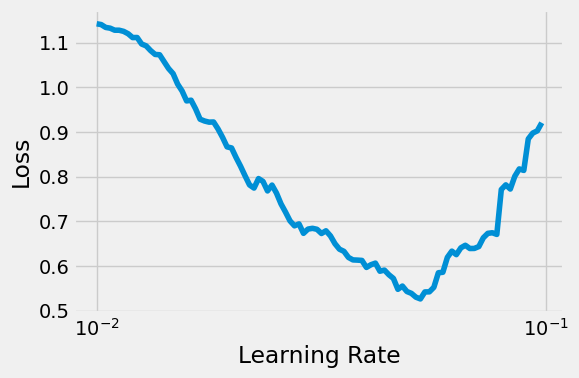

In [ ]:
torch.manual_seed(13)
model_cnn = CNN2(5)
multi_loss_fn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01)
sbs = StepByStep(model_cnn, optimizer_cnn, multi_loss_fn)
tracking, fig = sbs.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

And this is basically identical to the off-the-shelf one.

Repeated `lr_range_test` gives slightly differnt graph but doesn't affect the model and optimizer states.

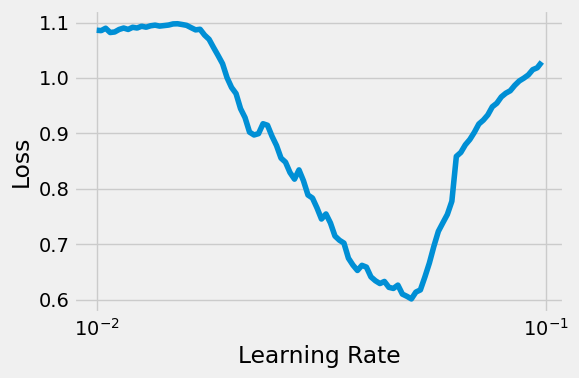

In [ ]:
tracking, fig = sbs.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

# Adam - adaptive gradients

Adam is optimizer that instead of gradients (used in SGD) calculates **adaptive_gradients**, taking bias-corrected exponentially-weighted moving average (EWMA) of gradients and gradients squared. This makes convergence to the minimum loss faster then in a regular SGD.

$$
\large \text{adapted-gradient}_t = \frac{\text{Bias Corrected EWMA}_t(\beta_1, \text{gradients})}{\sqrt{\text{Bias Corrected EWMA}_t(\beta_2, \text{gradients}^2)}+\epsilon}
$$

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\end{aligned}
$$

Basic Adam definition from PyTorch: `optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)`.

# SGD - with momentum

SGD also has variations that are used in practice (especially after being combined with scheduler), these variations are Momentum and Nestorov:

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} &&&-&& \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t &-&\beta &\eta\ \text{mo}_t
\end{aligned}
$$

They are invoked using parameters:

`optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

# Schedulers

We can combine any optimizer with `Schedulers`. The general idea behind using a scheduler is to allow the optimizer to alternate between exploring the loss surface (high learning rate phase) and targeting a minimum (low learning rate phase).

![cyclycLR_modes](images/cyclicLR_modes.png)

![optimizer_and_scheduler_examples](images/optimizer_and_scheduler_examples.png)

Let's increase the dropout rate for fun:

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.75E-02


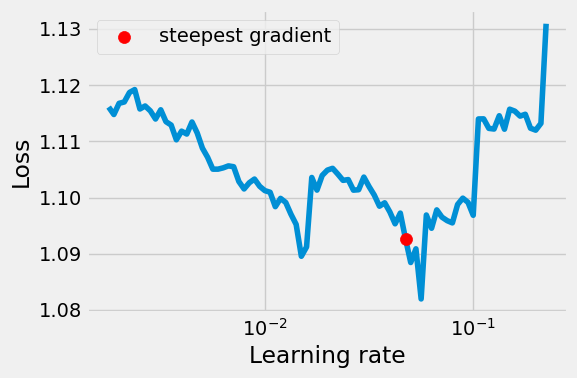

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(13)
model_cnn3 = CNN2(n_filters=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(model_cnn3, optimizer_cnn3, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=3e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

the LRFinder curve doesn't look as pretty as before, but does the job.

Let's go with the suggestion of 4.75e-2:

So **without** the `Scheduler`:

In [ ]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_filters=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.0475, momentum=0.9, nesterov=True)
sbs_cnn3 = StepByStep(model_cnn3, optimizer_cnn3, multi_loss_fn)
sbs_cnn3.set_loaders(train_loader, val_loader)
sbs_cnn3.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:38<00:00,  9.88s/it]


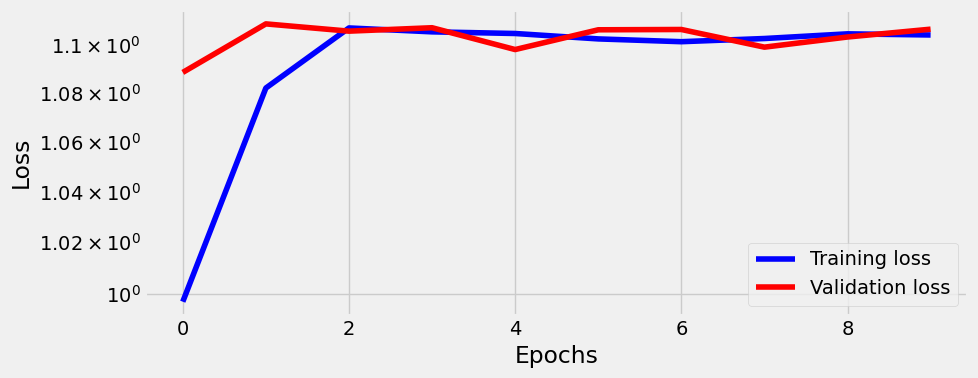

tensor([ 840, 2520]) tensor([124, 372])


33.33

In [ ]:
fig = sbs_cnn3.plot_losses()
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))
sbs_cnn3.accuracy

And this is quite bad loss curve, since `lr` is **quite** high.

With the `Scheduler` however:

In [ ]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_filters=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.0475, momentum=0.9, nesterov=True)
sbs_cnn3 = StepByStep(model_cnn3, optimizer_cnn3, multi_loss_fn)
sbs_cnn3.set_loaders(train_loader, val_loader)
scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=5e-2, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn3.set_lr_scheduler(scheduler)
sbs_cnn3.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.67s/it]


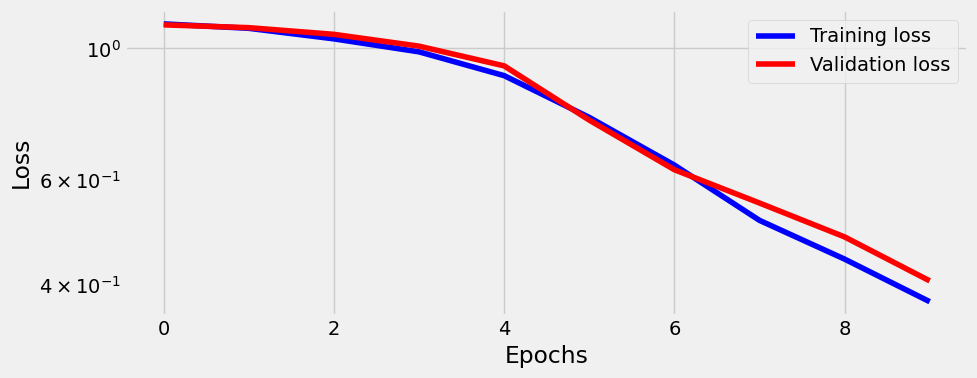

tensor([2483, 2520]) tensor([304, 372])


81.72

In [ ]:
fig = sbs_cnn3.plot_losses()
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))
sbs_cnn3.accuracy

In [ ]:
sbs_cnn3.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.74s/it]


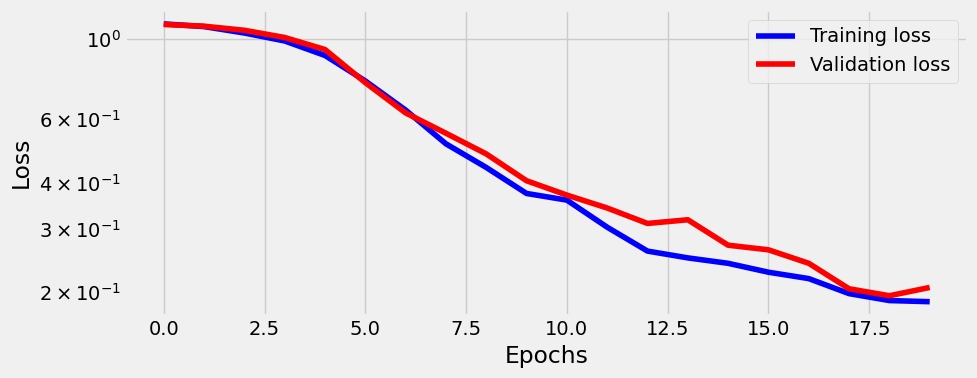

tensor([2505, 2520]) tensor([336, 372])


90.32

In [ ]:
fig = sbs_cnn3.plot_losses()
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))
sbs_cnn3.accuracy

90.3% accuracy is comparable with `Adam` optimizer used initially (even though Dropout rate was 0.3).

Extra training doesn't help btw, one could play for example with `n_filters`, or different model.